In [1]:
## Working Notebook to add confeernce affilation to game data table

# Dependencies

import pandas as pd
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
# import sns
import seaborn as sns

# Load Data
conference_df = pd.read_csv('../data/yearly_conference_members.csv')
games_df = pd.read_csv('../data/cfb_scores_all_years.csv')

# rename Unnamed: 0 to year in conference_df
conference_df = conference_df.rename(columns={'Unnamed: 0': 'Year'})



# Convert string representations of lists back into actual lists
for col in conference_df.columns[1:]:
    conference_df[col] = conference_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


c:\Users\Justin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Justin\AppData\Local\Temp\ipykernel_5348\331398202.py:15: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('../data/cfb_scores_all_years.csv')


In [7]:
# conference_df.sample(5)

games_df.sample(20)

# value countes of winner_ranking
# games_df['Winner_Ranking'].value_counts()

# find any rows with (number) in the winner olumn



,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,Year,Time,Unnamed: 7,Winner_Ranking,Loser_Ranking


In [17]:
# Function to retrieve the conference based on year and team name
def get_conference_adjusted(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Create a lookup dictionary for team-year to conference mapping
conference_lookup = {}

for _, row in conference_df.iterrows():
    year = row['Year']
    for col, teams in row[1:].items():
        for team in teams:
            conference_lookup[(year, team)] = col

# Use the adjusted function to assign conference for Winner and Loser
games_df['winner_conference'] = games_df.apply(lambda row: get_conference_adjusted(row['Year'], row['Winner'], conference_lookup), axis=1)
games_df['loser_conference'] = games_df.apply(lambda row: get_conference_adjusted(row['Year'], row['Loser'], conference_lookup), axis=1)

# Classify games as Regular Season or Post Season based on Date
games_df['Date'] = pd.to_datetime(games_df['Date'], errors='coerce')  # Convert the Date column to datetime format
games_df['season_type'] = games_df.apply(lambda row: "Post Season" if (row['Date'].month == 12 and row['Date'].day > 15) or row['Date'].month == 1 else "Regular Season", axis=1)


In [18]:
# games_df.info()

# value counts for winner and loser conference
games_df['winner_conference'].value_counts()
games_df['loser_conference'].value_counts()

# OUTPUT CSV TO TEMP FOLDER
games_df.to_csv('../TEMP/ADJUSTED_cfb_scores_all_years.csv', index=False)

# Load The FBS Teams Table
fbs_teams_df = pd.read_csv('..\data\cfb_d1_teams_with_coordinates.csv')

In [19]:
games_df.head()
games_df.columns

Index(['Rk', 'Wk', 'Date', 'Day', 'Winner', 'Pts', 'Unnamed: 6', 'Loser',
       'Pts.1', 'Notes', 'Year', 'Time', 'Unnamed: 7', 'Winner_Ranking',
       'Loser_Ranking', 'winner_conference', 'loser_conference',
       'season_type'],
      dtype='object')

In [20]:
adjusted_games_df = games_df

# Extract the list of top division teams
d1_teams_list = fbs_teams_df['Team'].tolist()

# Filter the historical game data to only include games involving these teams
filtered_games_df = adjusted_games_df[(adjusted_games_df['Winner'].isin(d1_teams_list)) | (adjusted_games_df['Loser'].isin(d1_teams_list))]

# Display basic information and a sample of rows from the filtered dataframe
filtered_games_info = filtered_games_df.info()
filtered_games_sample = filtered_games_df.sample(30)

filtered_games_info, filtered_games_sample


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65508 entries, 0 to 81603
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Rk                 65508 non-null  int64         
 1   Wk                 65508 non-null  int64         
 2   Date               65508 non-null  datetime64[ns]
 3   Day                65508 non-null  object        
 4   Winner             65508 non-null  object        
 5   Pts                65507 non-null  float64       
 6   Unnamed: 6         24057 non-null  object        
 7   Loser              65508 non-null  object        
 8   Pts.1              65507 non-null  float64       
 9   Notes              4966 non-null   object        
 10  Year               65508 non-null  int64         
 11  Time               7080 non-null   object        
 12  Unnamed: 7         3440 non-null   object        
 13  Winner_Ranking     0 non-null      float64       
 14  Loser_

(None,
         Rk  Wk       Date  Day               Winner   Pts Unnamed: 6  \
 28944   53   3 1949-09-24  Sat              Colgate  32.0        NaN   
 47455  305   5 1977-10-01  Sat               Temple   6.0          @   
 4951   351   8 1905-11-04  Sat            Texas A&M  24.0          N   
 68012  550  10 2006-11-04  Sat              Houston  27.0        NaN   
 80261  441   8 2021-10-16  Sat       Colorado State  36.0        NaN   
 76961  357   7 2017-10-07  Sat     Florida Atlantic  58.0        NaN   
 25220  360   7 1942-10-25  Sun       Boston College  27.0        NaN   
 4354   234   6 1904-10-22  Sat              Chicago  32.0        NaN   
 10832  307   7 1919-11-01  Sat               Kansas  16.0        NaN   
 21155  308   5 1936-10-17  Sat               Purdue  35.0          @   
 34995   79   3 1959-09-26  Sat          North Texas  31.0          @   
 33209   60   3 1956-09-29  Sat               Baylor  27.0        NaN   
 38034   75   3 1964-09-26  Sat             

In [21]:
# Adjust the conference lookup to assign "Independent/Unknown" for missing teams
def get_conference_adjusted(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Rename df to games_df_new
games_df_new = games_df

# Use the adjusted function to assign conference for Winner and Loser
games_df_new['winner_conference'] = games_df_new.apply(lambda row: get_conference_adjusted(row['Year'], row['Winner'], conference_lookup), axis=1)
games_df_new['loser_conference'] = games_df_new.apply(lambda row: get_conference_adjusted(row['Year'], row['Loser'], conference_lookup), axis=1)

# Classify games as Regular Season or Post Season based on Date
games_df_new['Date'] = pd.to_datetime(games_df_new['Date'], errors='coerce')  # Convert the Date column to datetime format
games_df_new['season_type'] = games_df_new.apply(lambda row: "Post Season" if (row['Date'].month == 12 and row['Date'].day > 15) or row['Date'].month == 1 else "Regular Season", axis=1)



# Classify games as Conference or Non-Conference - Teams in the same conference are considered conference games - Indepentent teams are allway considered non-conference games
games_df_new['game_type'] = games_df_new.apply(lambda row: "Conference" if row['winner_conference'] == row['loser_conference'] else "Non-Conference", axis=1)

# If both winner_conference and loser_conference are "Independent/Unknown", then classify the game as "Non-Conference"
games_df_new['game_type'] = games_df_new.apply(lambda row: "Non-Conference" if row['winner_conference'] == "Independent/Unknown" and row['loser_conference'] == "Independent/Unknown" else "Conference", axis=1)


# Display the updated dataframe with the new columns
games_df_new.sample(30)



,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,Year,Time,Unnamed: 7,Winner_Ranking,Loser_Ranking,winner_conference,loser_conference,season_type,game_type
59889,151,4,1995-09-16,Sat,Texas Tech,41.0,NaN,Missouri,14.0,NaN,1995,NaN,NaN,NaN,NaN,Southwest Conference,Big 8 Conference,Regular Season,Conference
37616,278,6,1963-10-19,Sat,Pittsburgh,13.0,@,West Virginia,10.0,NaN,1963,NaN,NaN,NaN,NaN,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference
53666,329,8,1985-10-19,Sat,Air Force,35.0,@,Colorado State,19.0,NaN,1985,NaN,NaN,NaN,NaN,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference
65351,102,3,2003-09-06,Sat,North Texas,52.0,NaN,Baylor,14.0,NaN,2003,NaN,NaN,NaN,NaN,Sun Belt Conference,Independent/Unknown,Regular Season,Conference
22874,614,11,1938-11-24,Thu,North Carolina,20.0,@,Virginia,0.0,NaN,1938,NaN,NaN,NaN,NaN,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference
16539,288,6,1929-10-26,Sat,Indiana,0.0,@,Ohio State,0.0,NaN,1929,NaN,NaN,NaN,NaN,Big Ten Conference,Big Ten Conference,Regular Season,Conference
50021,363,7,1980-10-11,Sat,Ohio State,63.0,@,Northwestern,0.0,NaN,1980,NaN,NaN,NaN,NaN,Big Ten Conference,Big Ten Conference,Regular Season,Conference
81298,591,11,2022-11-02,Wed,Bowling Green,13.0,NaN,Western Michigan,9.0,NaN,2022,7:00 PM,NaN,NaN,NaN,Mid-American Conference,Mid-American Conference,Regular Season,Conference
30874,61,3,1952-09-27,Sat,Eastern New Mexico,21.0,@,Northern Arizona,7.0,NaN,1952,NaN,NaN,NaN,NaN,Independent/Unknown,Border Conference,Regular Season,Conference
23535,610,11,1939-11-25,Sat,William & Mary,7.0,@,Richmond,0.0,NaN,1939,NaN,NaN,NaN,NaN,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference


In [22]:
## Extract Notes for Bowl Game and Champ Game Names

# Value COunts
games_df_new['Notes'].value_counts().head(20)

# If notes contains Bowl, then copy the notes to the bowl_game column
games_df_new['bowl_game'] = games_df_new.apply(lambda row: row['Notes'] if isinstance(row['Notes'], str) and 'Bowl' in row['Notes'] else None, axis=1)
# Clear the Bowl Cells from the Notes Column
games_df_new['Notes'] = games_df_new.apply(lambda row: None if isinstance(row['Notes'], str) and 'Bowl' in row['Notes'] else row['Notes'], axis=1)




# value counts for bowl_game
games_df_new['bowl_game'].value_counts()
# Notes value count
games_df_new['Notes'].value_counts()

# Save new Csv to data folder as game_info_v2
games_df_new.to_csv('../data/game_info_v2.csv', index=False)


In [23]:
## value counts for game_type
games_df_new['season_type'].value_counts()


# # # value count for winner_conference
games_df_new['winner_conference'].value_counts()

# # # value count for loser_conference
# games_df['loser_conference'].value_counts()


Independent/Unknown             40425
Big Ten Conference               7079
SEC                              5213
Mid-American Conference          3989
Pac-12 Conference                3907
ACC                              3345
Big 8 Conference                 2821
Southwest Conference             2738
Pacific Coast Conference         1969
Conference USA                   1570
Missouri Valley Conference       1517
Western Athletic Conference      1498
Big East Conference              1336
Ivy League                        987
Sun Belt Conference               984
Border Conference                 726
Skyline Conference                687
Mountain West Conference          675
American Athletic Conference      138
Name: winner_conference, dtype: int64

In [24]:
# save csv to data folder as game_info_v2
games_df_new.to_csv('../data/game_info_v2.csv', index=False)

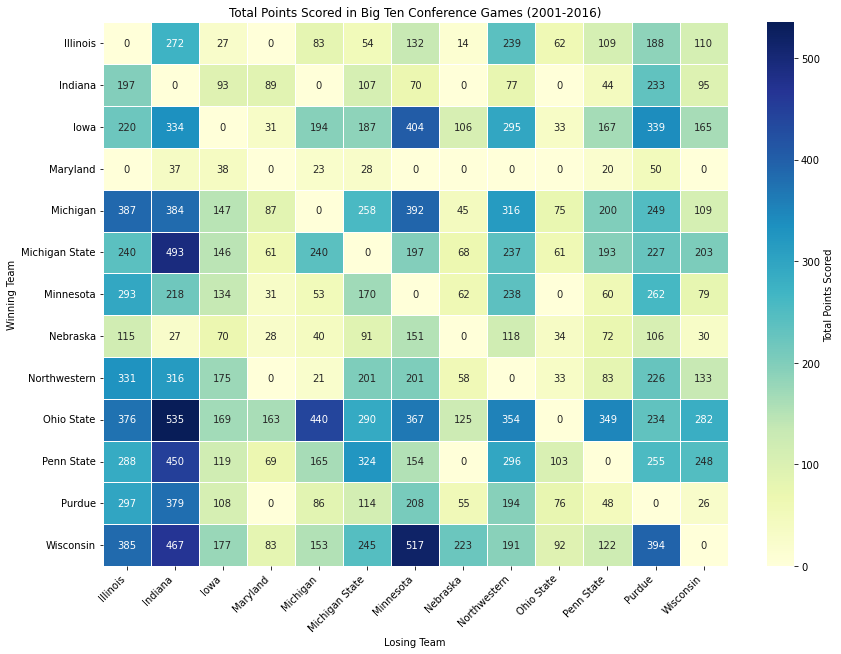

In [25]:
game_data = games_df_new

# Filter data to only include games from 2011-2016, within the Big Ten Conference, and that are conference games
big_ten_data = game_data[(game_data['Year'].between(2001, 2016)) & 
                         (game_data['winner_conference'] == 'Big Ten Conference') &
                          (game_data['loser_conference'] == 'Big Ten Conference') & 
                         (game_data['game_type'] == 'Conference')]

# Group by winner and loser to get sum of points scored
points_scored_big_ten = big_ten_data.groupby(['Winner', 'Loser']).agg({'Pts': 'sum'}).reset_index()

def plot_big_ten_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('Winner', 'Loser', 'Pts')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Total Points Scored'})
    plt.title('Total Points Scored in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2011-2016
plot_big_ten_heatmap(points_scored_big_ten)


C:\Users\Justin\AppData\Local\Temp\ipykernel_14504\1094634383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_ten_data_diff['point_diff'] = big_ten_data_diff['Pts'] - big_ten_data_diff['Pts.1']


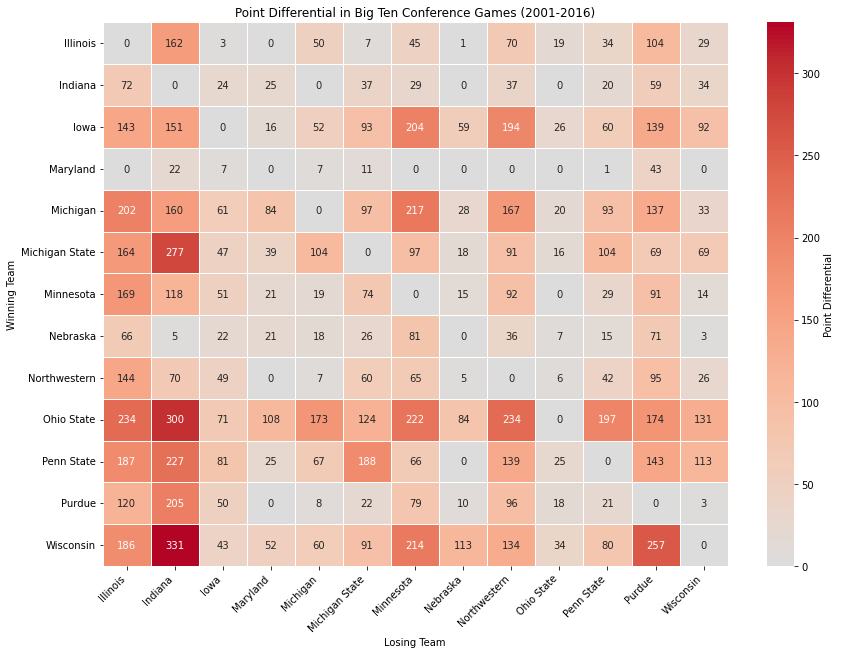

In [26]:
# Filter data to only include games from 2001-2016, within the Big Ten Conference, and that are conference games
big_ten_data_diff = game_data[(game_data['Year'].between(2001, 2016)) & 
                              (game_data['winner_conference'] == 'Big Ten Conference') &
                              (game_data['loser_conference'] == 'Big Ten Conference') & 
                              (game_data['game_type'] == 'Conference')]

# Compute point differential for each game
big_ten_data_diff['point_diff'] = big_ten_data_diff['Pts'] - big_ten_data_diff['Pts.1']

# Group by winner and loser to get sum of point differentials
point_diff_big_ten = big_ten_data_diff.groupby(['Winner', 'Loser']).agg({'point_diff': 'sum'}).reset_index()

def plot_big_ten_diff_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('Winner', 'Loser', 'point_diff')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="coolwarm", center=0, linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Point Differential'})
    plt.title('Point Differential in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2001-2016
plot_big_ten_diff_heatmap(point_diff_big_ten)
